In [1354]:
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from fuzzywuzzy import process
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold, cross_val_score
import pickle
import import_ipynb
from datetime import datetime
from prophet import Prophet


from sklearn.ensemble import RandomForestClassifier 
import warnings
warnings.simplefilter(action='ignore')


In [1356]:
df=pd.read_csv("C:\\Users\\KIIT\\Downloads\\personal_transactions.csv")
df.head()

,Date,Description,Amount,Transaction Type,Category,Account Name,Unnamed: 6,Unnamed: 7,Unnamed: 8
0,01-01-2018,Shopping,700.00,debit,Shopping,Platinum Card,NaN,NaN,NaN
1,01-02-2018,Mortgage Payment,1247.44,debit,Mortgage & Rent,Checking,NaN,NaN,NaN
2,01-02-2018,Thai Restaurant,600.00,debit,Restaurants,Silver Card,NaN,NaN,NaN
3,01-03-2018,Credit Card Payment,2298.09,credit,Credit Card Payment,Platinum Card,NaN,NaN,NaN
4,01-04-2018,Netflix,400.00,debit,Movies & DVDs,Platinum Card,NaN,NaN,NaN


In [1358]:
df = df.drop(columns=['Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8'])
df.head()

,Date,Description,Amount,Transaction Type,Category,Account Name
0,01-01-2018,Shopping,700.00,debit,Shopping,Platinum Card
1,01-02-2018,Mortgage Payment,1247.44,debit,Mortgage & Rent,Checking
2,01-02-2018,Thai Restaurant,600.00,debit,Restaurants,Silver Card
3,01-03-2018,Credit Card Payment,2298.09,credit,Credit Card Payment,Platinum Card
4,01-04-2018,Netflix,400.00,debit,Movies & DVDs,Platinum Card


In [1360]:
category_mapping = {
    'Shopping': 'Shopping',
    'Electronics & Software': 'Electronics',
    'Mortgage & Rent': 'Housing & Utilities',
    'Credit Card Payment': 'Financial Expenses',
    'Paycheck': 'Income',
    'Restaurants': 'Food & Dining',
    'Fast Food': 'Food & Dining',
    'Coffee Shops': 'Food & Dining',
    'Food & Dining': 'Food & Dining',
    'Movies & DVDs': 'Entertainment',
    'Entertainment': 'Entertainment',
    'Music': 'Entertainment',
    'Television': 'Entertainment',
    'Home Improvement': 'Housing & Utilities',
    'Utilities': 'Housing & Utilities',
    'Internet': 'Housing & Utilities',
    'Mobile Phone': 'Housing & Utilities',
    'Auto Insurance': 'Housing & Utilities',
    'Gas & Fuel': 'Transport',
    'Haircut': 'Personal Care',
    'Alcohol & Bars': 'Personal Care'
}

df['Category'] = df['Category'].replace(category_mapping)
df["Description"] = df["Description"].astype(str).str.lower()
df.head()



,Date,Description,Amount,Transaction Type,Category,Account Name
0,01-01-2018,shopping,700.00,debit,Shopping,Platinum Card
1,01-02-2018,mortgage payment,1247.44,debit,Housing & Utilities,Checking
2,01-02-2018,thai restaurant,600.00,debit,Food & Dining,Silver Card
3,01-03-2018,credit card payment,2298.09,credit,Financial Expenses,Platinum Card
4,01-04-2018,netflix,400.00,debit,Entertainment,Platinum Card


In [1362]:
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 808 entries, 0 to 807
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Date              805 non-null    object 
 1   Description       808 non-null    object 
 2   Amount            805 non-null    float64
 3   Transaction Type  805 non-null    object 
 4   Category          805 non-null    object 
 5   Account Name      805 non-null    object 
dtypes: float64(1), object(5)
memory usage: 38.0+ KB


Date                3
Description         0
Amount              3
Transaction Type    3
Category            3
Account Name        3
dtype: int64

                                                  PRE-PROCESSING

In [1365]:
df["Amount"].fillna(df["Amount"].median(), inplace=True)
df["Transaction Type"].fillna(df["Transaction Type"].mode()[0], inplace=True)
df["Category"].fillna(df["Category"].mode()[0], inplace=True)
df["Account Name"].fillna(df["Account Name"].mode()[0], inplace=True)
df.dropna(subset=["Date"], inplace=True)  # Drop rows where Date is missing

In [1367]:
df.isnull().sum()

Date                0
Description         0
Amount              0
Transaction Type    0
Category            0
Account Name        0
dtype: int64

In [1369]:
df["Date"] = pd.to_datetime(df["Date"], format='mixed', dayfirst=False)
df["Day"] = df["Date"].dt.day
df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month
df["DayOfWeek"] = df["Date"].dt.dayofweek  # 0 = Monday, 6 = Sunday
df = df.drop(columns=["Date"])
 
df.head()


,Description,Amount,Transaction Type,Category,Account Name,Day,Year,Month,DayOfWeek
0,shopping,700.00,debit,Shopping,Platinum Card,1,2018,1,0
1,mortgage payment,1247.44,debit,Housing & Utilities,Checking,2,2018,1,1
2,thai restaurant,600.00,debit,Food & Dining,Silver Card,2,2018,1,1
3,credit card payment,2298.09,credit,Financial Expenses,Platinum Card,3,2018,1,2
4,netflix,400.00,debit,Entertainment,Platinum Card,4,2018,1,3


In [1372]:
transaction_mapping = {"debit": 0, "credit": 1}
df["Transaction Type"] = df["Transaction Type"].map(transaction_mapping)


category_encoder = LabelEncoder()
df["Category"] = category_encoder.fit_transform(df["Category"])
category_mapping = dict(zip(category_encoder.classes_, range(len(category_encoder.classes_))))
print("Category Mapping:", category_mapping)


Category Mapping: {'Electronics': 0, 'Entertainment': 1, 'Financial Expenses': 2, 'Food & Dining': 3, 'Groceries': 4, 'Housing & Utilities': 5, 'Income': 6, 'Personal Care': 7, 'Shopping': 8, 'Transport': 9}


In [1374]:
account_encoder = LabelEncoder()
df["Account Name"] = account_encoder.fit_transform(df["Account Name"])
account_mapping = dict(zip(account_encoder.classes_, range(len(account_encoder.classes_))))
print("Account Name Mapping:", account_mapping)


Account Name Mapping: {'Checking': 0, 'Platinum Card': 1, 'Silver Card': 2}


In [1376]:
y_train.value_counts()

Category
5    147
2    122
3    104
4     81
1     41
8     40
6     40
9     38
7     28
0      3
Name: count, dtype: int64

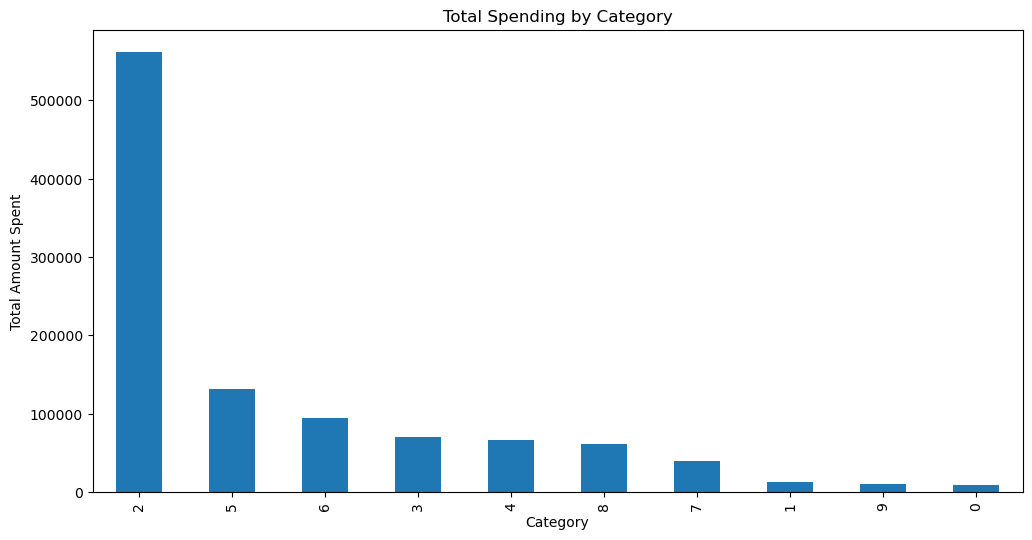

In [1378]:
df.groupby('Category')['Amount'].sum().sort_values(ascending=False).plot(kind='bar', figsize=(12,6))
plt.title("Total Spending by Category")
plt.xlabel("Category")
plt.ylabel("Total Amount Spent")
plt.show()


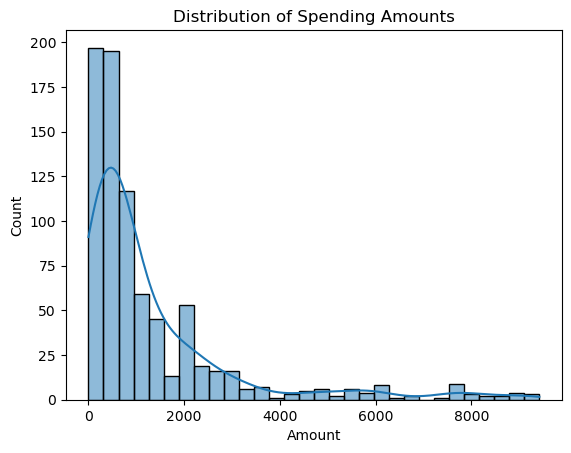

In [1380]:
sns.histplot(df['Amount'], bins=30, kde=True)
plt.title("Distribution of Spending Amounts")
plt.show()


In [1382]:
df["Original_Amount"] = df["Amount"]  
scaler = StandardScaler()
df["Amount"] = scaler.fit_transform(df[["Amount"]])

In [1384]:

df.head()
df = df.dropna(subset=['Description'])

# Step 2: Convert Transaction Descriptions to TF-IDF Features

vectorizer = TfidfVectorizer()
X_text = vectorizer.fit_transform(df["Description"]).toarray()  

# Convert "Transaction Type" and "Amount" into a DataFrame and concatenate with text features
X_numeric = df[["Transaction Type", "Amount"]].values
X = np.hstack((X_text, X_numeric))  # Merge text & numeric features
y = df["Category"]


In [1386]:
df.head()

,Description,Amount,Transaction Type,Category,Account Name,Day,Year,Month,DayOfWeek,Original_Amount
0,shopping,-0.350595,0,8,1,1,2018,1,0,700.00
1,mortgage payment,-0.035919,0,5,0,2,2018,1,1,1247.44
2,thai restaurant,-0.408077,0,3,2,2,2018,1,1,600.00
3,credit card payment,0.568010,1,2,1,3,2018,1,2,2298.09
4,netflix,-0.523040,0,1,1,4,2018,1,3,400.00


       ----------------------------------------------------Expense Categorization----------------------------------------------------

In [1389]:

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Data split successfully: Train size = {X_train.shape}, Test size = {X_test.shape}")


Data split successfully: Train size = (644, 92), Test size = (161, 92)


In [1391]:
model = RandomForestClassifier(class_weight="balanced", random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
predictions = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, predictions))
print("Classification Report:\n", classification_report(y_test, predictions))


Accuracy: 0.9875776397515528
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00        21
           3       1.00      0.96      0.98        26
           4       1.00      1.00      1.00        24
           5       0.97      1.00      0.99        33
           6       1.00      1.00      1.00         6
           7       0.91      1.00      0.95        10
           8       1.00      1.00      1.00        20
           9       1.00      0.92      0.96        13

    accuracy                           0.99       161
   macro avg       0.99      0.99      0.99       161
weighted avg       0.99      0.99      0.99       161



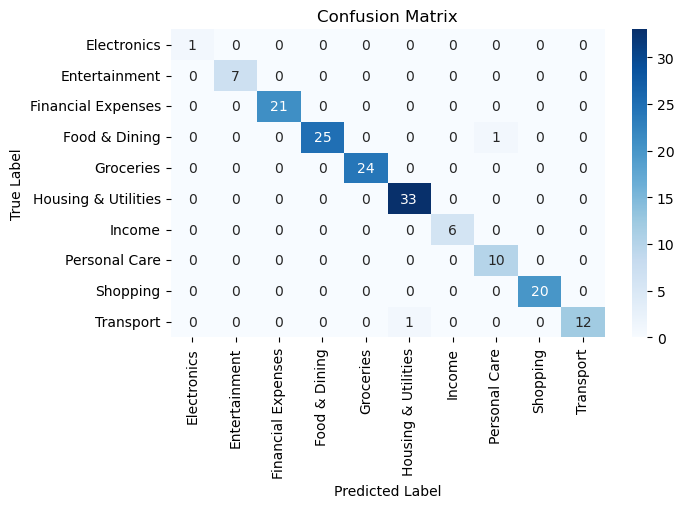

In [1393]:

cm = confusion_matrix(y_test, predictions)

# Plot confusion matrix
plt.figure(figsize=(7, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=category_encoder.classes_, yticklabels=category_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [1395]:

train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

train_acc = accuracy_score(y_train, train_preds)
test_acc = accuracy_score(y_test, test_preds)

print(f"Training Accuracy: {train_acc:.4f}")
print(f"Testing Accuracy: {test_acc:.4f}")


Training Accuracy: 1.0000
Testing Accuracy: 0.9876


In [1397]:
with open("random_forest_model.pkl", "wb") as file:
    pickle.dump(model, file)

with open("vectorizer.pkl", "wb") as file:
    pickle.dump(vectorizer, file)
    
# Function to load the model
def load_model(filename="model.pkl"):
    with open(filename, 'rb') as file:
        model = pickle.load(file)
    print(f"Model loaded from {filename}")
    return model

In [1399]:
with open("category_encoder.pkl", "wb") as file:
    pickle.dump(category_encoder, file)


In [1401]:
rf_model = load_model("random_forest_model.pkl")
print(rf_model)

Model loaded from random_forest_model.pkl
RandomForestClassifier(class_weight='balanced', random_state=42)


In [1403]:
def classify_transaction(description, amount, transaction_type, model, vectorizer):
    transformed_desc = vectorizer.transform([description]).toarray()
    input_features = np.hstack((transformed_desc, [[transaction_type, amount]]))  # Merge features
    predicted_category_encoded = model.predict(input_features)[0]
    predicted_category_text = category_encoder.inverse_transform([predicted_category_encoded])[0]  # Convert back
    return predicted_category_text

In [1407]:
test_desc = "Netflix"
test_amount = 300
test_transaction_type = transaction_mapping["debit"]  # Assuming it's a debit transaction

predicted_category = classify_transaction(test_desc, test_amount, test_transaction_type, model, vectorizer)
print(f"Predicted Category for '{test_desc}': {predicted_category}")

Predicted Category for 'Netflix': Entertainment


                        ----------------------------SPENDING PATTERN ANALYSIS-------------------------------------------------

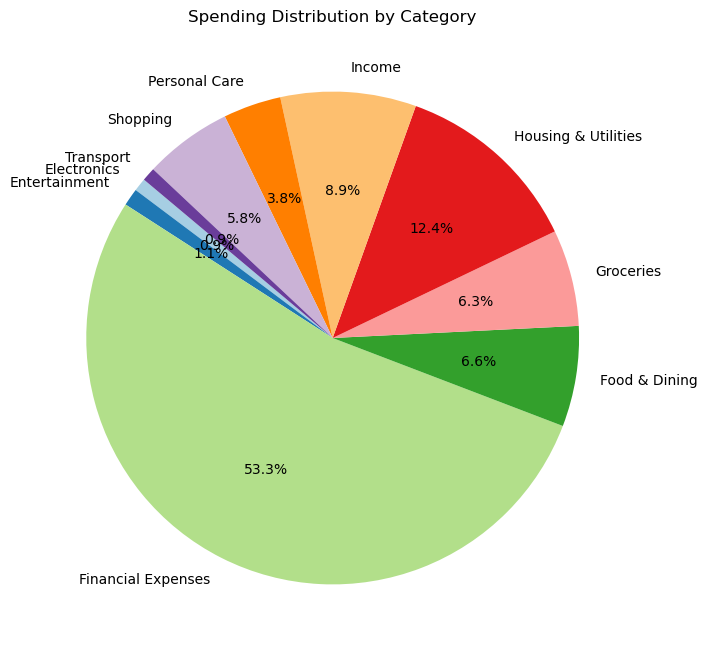

In [1343]:
category_mapping = dict(zip(category_encoder.transform(category_encoder.classes_), category_encoder.classes_))
category_spending = df.groupby("Category")["Original_Amount"].sum()
category_spending.index = category_spending.index.map(category_mapping)

# Plot the pie chart
plt.figure(figsize=(8, 8))
plt.pie(category_spending, labels=category_spending.index, autopct="%1.1f%%", 
        colors=plt.cm.Paired.colors, startangle=140)

plt.title("Spending Distribution by Category")
plt.show()

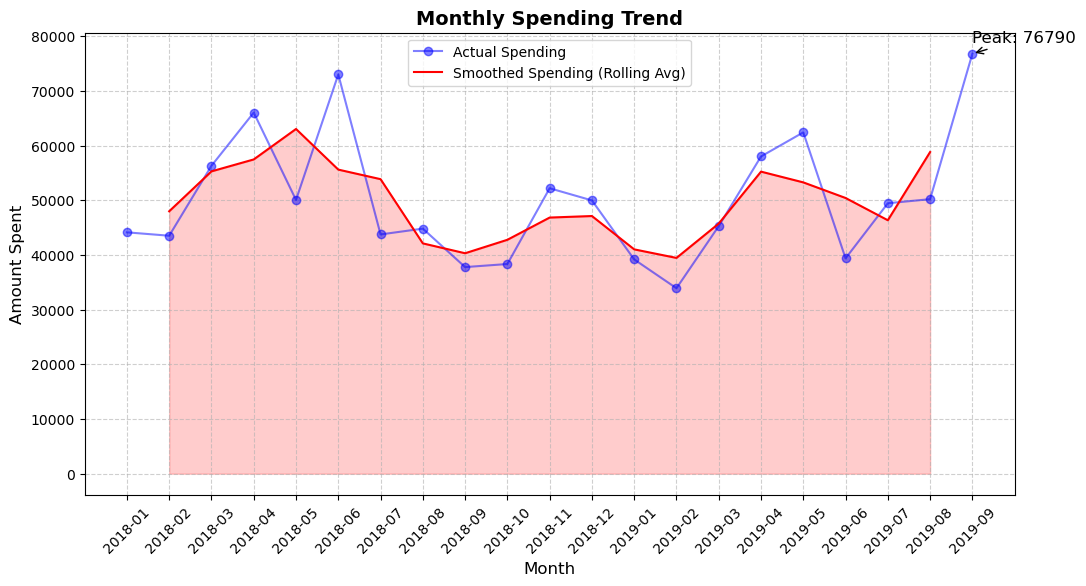

In [1345]:

df["Year-Month"] = df["Year"].astype(str) + "-" + df["Month"].astype(str).str.zfill(2)

monthly_spending = df.groupby("Year-Month")["Original_Amount"].sum().abs()

monthly_spending_smooth = monthly_spending.rolling(window=3, center=True).mean()

plt.figure(figsize=(12, 6))
plt.plot(monthly_spending.index, monthly_spending, marker="o", linestyle="-", color="blue", alpha=0.5, label="Actual Spending")
plt.plot(monthly_spending.index, monthly_spending_smooth, marker="", linestyle="-", color="red", label="Smoothed Spending (Rolling Avg)")

plt.fill_between(monthly_spending.index, monthly_spending_smooth, alpha=0.2, color="red")

max_spent_month = monthly_spending.idxmax()
plt.annotate(f"Peak: {int(monthly_spending[max_spent_month])}", 
             xy=(max_spent_month, monthly_spending[max_spent_month]), 
             xytext=(max_spent_month, monthly_spending[max_spent_month] + 2000),
             arrowprops=dict(facecolor='black', arrowstyle="->"),
             fontsize=12, color="black")

plt.xlabel("Month", fontsize=12)
plt.ylabel("Amount Spent", fontsize=12)
plt.title("Monthly Spending Trend", fontsize=14, fontweight="bold")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)

# Show plot
plt.show()


<Figure size 1200x600 with 0 Axes>

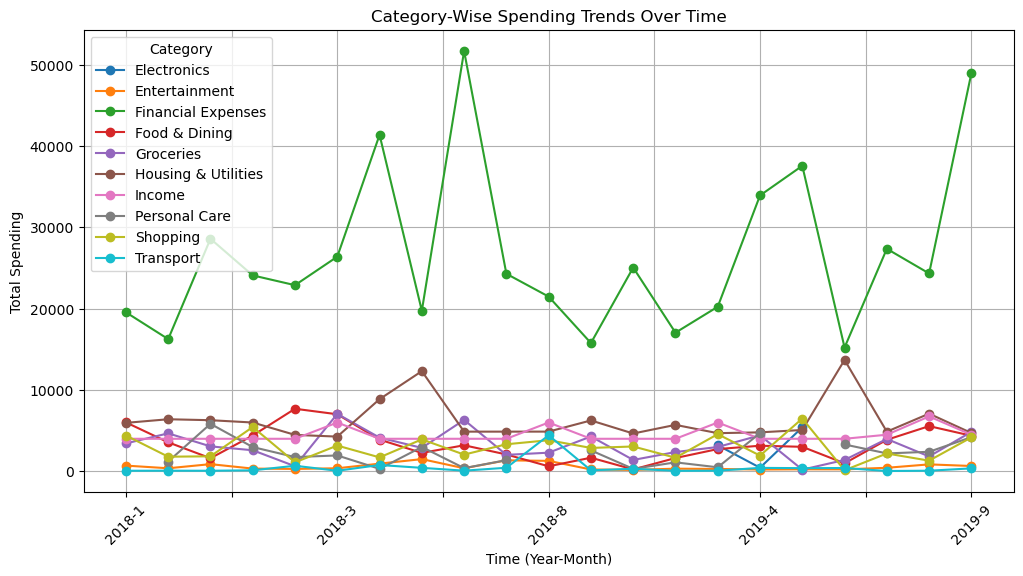

In [1347]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Create a 'time_period' column using Year & Month
df['time_period'] = df['Year'].astype(str) + '-' + df['Month'].astype(str)
df['Category'] = category_encoder.inverse_transform(df['Category'])


# Aggregate total spending per category per time period
category_trend = df.groupby(['time_period', 'Category'])['Original_Amount'].sum().unstack()

# Plot category-wise spending trends
plt.figure(figsize=(12, 6))
category_trend.plot(kind='line', marker='o', figsize=(12, 6), colormap='tab10')

plt.xlabel("Time (Year-Month)")
plt.ylabel("Total Spending")
plt.title("Category-Wise Spending Trends Over Time")
plt.xticks(rotation=45)
plt.legend(title="Category")
plt.grid(True)
plt.show()


In [1348]:

average_transaction_amount = df.groupby("Category")["Original_Amount"].mean().reset_index()

average_transaction_amount.columns = ["Category", "Average Amount"]

print(average_transaction_amount)


              Category  Average Amount
0          Electronics     2263.250000
1        Entertainment      250.770625
2   Financial Expenses     3930.354056
3        Food & Dining      535.117331
4            Groceries      636.211524
5  Housing & Utilities      726.593167
6               Income     2038.043478
7        Personal Care     1053.616316
8             Shopping     1016.296983
9            Transport      185.135294


                 --------------------------------- MONTHLY BUDGETING------------------------------------

In [1352]:

categories = ["Food & Dining", "Entertainment", "Shopping", "Transport", "Groceries" , "Personal Care"]
budget_dict = {}
for category in categories:
    budget = float(input(f"Enter your budget for {category}: "))
    budget_dict[category] = budget

# Convert budget dictionary to a DataFrame
budget_df = pd.DataFrame(list(budget_dict.items()), columns=["Category", "Budget"])
print("\nUser Budget Allocation:")
print(budget_df)


Enter your budget for Food & Dining:  45667
Enter your budget for Entertainment:  432
Enter your budget for Shopping:  213
Enter your budget for Transport:  567
Enter your budget for Groceries:  45342
Enter your budget for Personal Care:  345



User Budget Allocation:
        Category   Budget
0  Food & Dining  45667.0
1  Entertainment    432.0
2       Shopping    213.0
3      Transport    567.0
4      Groceries  45342.0
5  Personal Care    345.0


In [1259]:
df["Date"] = pd.to_datetime(df[["Year", "Month", "Day"]])
current_month = df[df["Date"].dt.month == pd.Timestamp.now().month]
actual_spending = current_month.groupby("Category")["Original_Amount"].sum()

# Convert to dictionary for easy comparison
actual_spending_dict = actual_spending.to_dict()
print(actual_spending_dict)

{'Electronics': 3200.99, 'Entertainment': 660.11, 'Financial Expenses': 46646.17, 'Food & Dining': 9750.74, 'Groceries': 10050.08, 'Housing & Utilities': 8957.95, 'Income': 12000.0, 'Personal Care': 2440.63, 'Shopping': 7733.42, 'Transport': 137.04}


In [1261]:
budget_vs_spending = {}

for category, budget in monthly_budget.items():
    actual = actual_spending_dict.get(category, 0)  # Default to 0 if no spending
    budget_vs_spending[category] = {
        "Budget": budget,
        "Actual Spending": actual,
        "Difference": budget - actual
    }

# Convert to DataFrame for better visualization
budget_df = pd.DataFrame.from_dict(budget_vs_spending, orient="index")
print(budget_df)


               Budget  Actual Spending  Difference
Food & Dining    8000          9750.74    -1750.74
Shopping         8500          7733.42      766.58
Transport         300           137.04      162.96
Entertainment     700           660.11       39.89
Personal Care    2500          2440.63       59.37
Groceries       10000         10050.08      -50.08


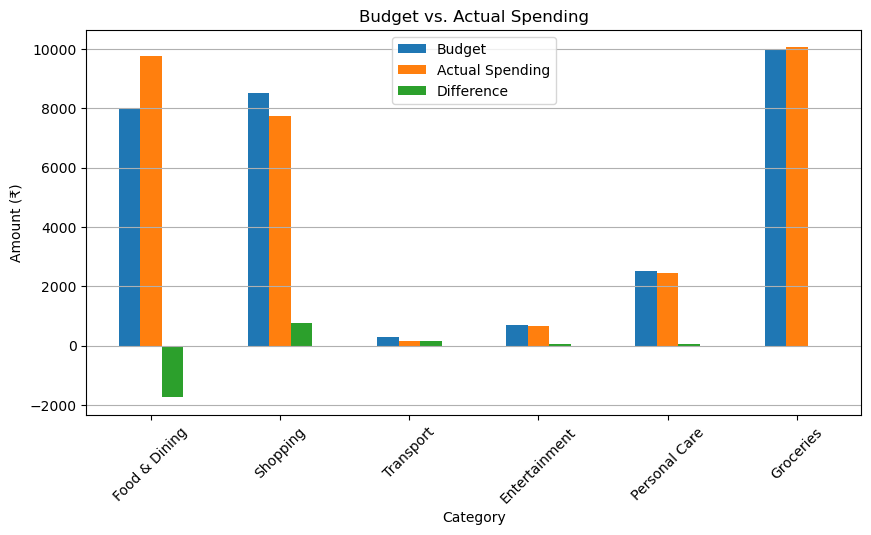

In [1263]:
import matplotlib.pyplot as plt

# Bar Chart: Budget vs. Actual Spending
budget_df.plot(kind='bar', figsize=(10, 5), title="Budget vs. Actual Spending")
plt.xlabel("Category")
plt.ylabel("Amount (₹)")
plt.xticks(rotation=45)
plt.grid(axis="y")
plt.show()


In [1265]:
# Check for overspending
for category, values in budget_vs_spending.items():
    if values["Actual Spending"] - values["Budget"] >=700:
        print(f"⚠️ ALERT: Overspent on {category}! Budget: ₹{values['Budget']}, Spent: ₹{values['Actual Spending']}")


⚠️ ALERT: Overspent on Food & Dining! Budget: ₹8000, Spent: ₹9750.74


In [1268]:
df = df.sort_values(by='Date')  

In [1270]:
df_monthly = df.groupby(pd.Grouper(key='Date', freq='M'))['Original_Amount'].sum().reset_index()


19:21:46 - cmdstanpy - INFO - Chain [1] start processing
19:21:47 - cmdstanpy - INFO - Chain [1] done processing


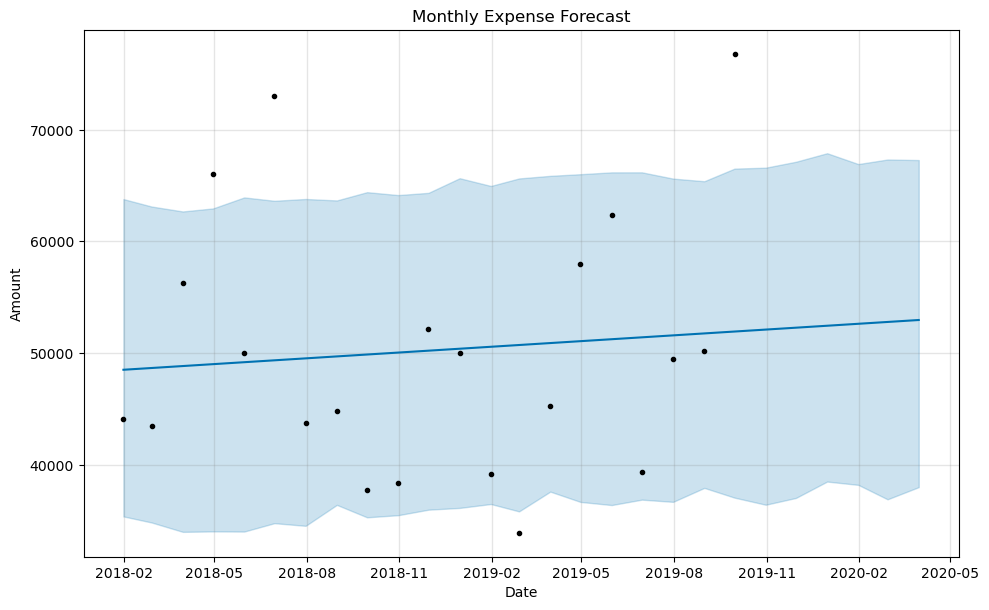

In [1272]:
#Prophet for forcasting

df_monthly.rename(columns={'Date': 'ds', 'Original_Amount': 'y'}, inplace=True)

# Initialize and fit the model
model = Prophet()
model.fit(df_monthly)

# Create a future dataframe for the next 6 months
future = model.make_future_dataframe(periods=6, freq='M')
forecast = model.predict(future)

# Plot the forecast
import matplotlib.pyplot as plt
model.plot(forecast)
plt.title("Monthly Expense Forecast")
plt.xlabel("Date")
plt.ylabel("Amount")
plt.show() 

In [1273]:
# Extract relevant columns
forecast_table = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

# Rename columns for clarity
forecast_table.rename(columns={'ds': 'Date', 'yhat': 'Predicted Expense', 
                               'yhat_lower': 'Lower Estimate', 
                               'yhat_upper': 'Upper Estimate'}, inplace=True)

# Show only future predictions
forecast_table = forecast_table[forecast_table['Date'] > df_monthly['ds'].max()]

# Display the table
print(forecast_table)


         Date  Predicted Expense  Lower Estimate  Upper Estimate
21 2019-10-31       52109.233367    36424.428153    66606.694358
22 2019-11-30       52278.408650    37032.058443    67136.917819
23 2019-12-31       52453.223110    38499.795155    67900.964468
24 2020-01-31       52628.037570    38202.716366    66930.630488
25 2020-02-29       52791.573677    36910.754566    67339.058503
26 2020-03-31       52966.388137    38000.314393    67289.035815


In [1276]:
import os
print(os.getcwd())  # This prints the current working directory


C:\Users\KIIT\Budget palnning


In [1280]:
!where python

C:\Users\KIIT\New folder\python.exe
C:\Users\KIIT\Desktop\Python1\python.exe
C:\Users\KIIT\Desktop\PYTHON\python.exe
C:\msys64\mingw64\bin\python.exe
C:\Users\KIIT\AppData\Local\Microsoft\WindowsApps\python.exe


In [1282]:
import sys
print(sys.executable)


C:\Users\KIIT\New folder\python.exe
